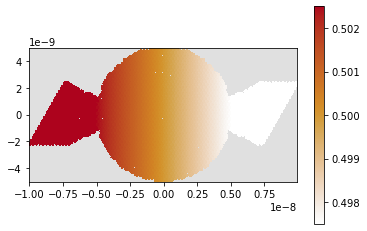

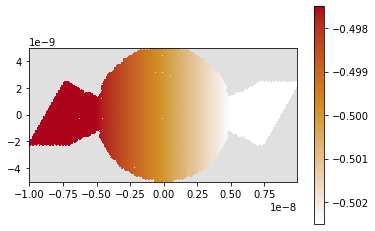

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import kwant
import scipy.sparse.linalg as sla
import scipy.linalg as la
from tqdm import tqdm
from math import *
import scipy.integrate as integrate
import tinyarray
import warnings

# suppress numpy overflow warnings
warnings.filterwarnings('ignore')


k_b = 1.380649e-23 #m^2 kg/s^2/K
q_e = 1.6e-19
h = 6.626176e-34 # in meter
hbar = 1.054571e-34 # in meters


sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

# h=4.1357e-15 # ev * s
# hbar = 6.5821e-16 # ev * s
# q_e = 1

ev_to_j = 1.6e-19



def make_system(r, t, tp, left_pot, right_pot, leads, parallel = True, lead_zeeman = True):
    norbs = 2
    side = -1e-10
    if r > 1:
        r *= 1e-10
    a = 2.46e-10 # angstroms
    # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    lat = kwant.lattice.general([(a, 0), (a*sin_30, a*cos_30)],
                                 [(0, 0), (0, a / sqrt(3))], norbs=norbs)
    electrode_bound = 1.5*r
    electrode_slope = 1/2

    b,c = lat.sublattices

    # hopping along the A field direction (perpendicular to B field)
    def hopy(site1, site2, B):
        x = site1.pos[0]
        return sigma_0 * t * np.exp(1j * B * x * q_e/hbar * a / sqrt(3))
        # try e / (hbar c)

    def hop_right(site1, site2, B):
        x_0 = site1.pos[0]
        const = -B*x_0*a/sqrt(12)-B*a**2/(4*sqrt(12)) # computed with pierels integral
        return sigma_0 * t * np.exp(1j * const * q_e/hbar)

    def hop_left(site1, site2, B):
        x_0 = site1.pos[0]
        const = -B*x_0*a/sqrt(12)+B*a**2/(4*sqrt(12)) # computed with pierels integral
        return sigma_0 * t * np.exp(1j * const * q_e/hbar)


    def circle(pos):
        x, y = pos
        return x**2 + y**2 < r**2

    # side = -1 for left, 1 for right
    def electrode_shape(pos):
        x,y = pos
        if x**2 + y**2 < r**2:
            return False
        return abs(y) + r/ 4 < side/abs(side) * x * electrode_slope and abs(x) < electrode_bound




    def make_lead(pot):
        # Start with an empty lead with a single square lattice
        lead_lattice = kwant.lattice.honeycomb(a, norbs=norbs)

        sym_lead = kwant.TranslationalSymmetry(lead_lattice.vec((-1,0)))
        lead = kwant.Builder(sym_lead, conservation_law=-sigma_z)

        def lead_shape(pos):
            x, y = pos
            return abs(y) + r/4 < electrode_slope * electrode_bound-2e-10


        def lead_potential(site, E_z):
            x,y=site.pos
            if not parallel and x < 0:
                E_z *= -1
            if not lead_zeeman:
                E_z = 0
            return pot * sigma_0 + E_z * sigma_z

        lead[lead_lattice.shape(lead_shape, (0, 0))] = lead_potential

        lead[lead_lattice.neighbors()] = t * sigma_0
        return lead

    def potential(site, E_z):
        x,y = site.pos
        m = (left_pot - right_pot)/(2*r)
        if not parallel and x < 0:
            E_z *= -1
        return (-m*(x-r) + right_pot) * sigma_0 + E_z * sigma_z


    def electrode_potential(site, E_z):
        x,y = site.pos
        if x < 0:
            pot = left_pot
        else:
            pot = right_pot
        if not parallel and x < 0:
            E_z *= -1
        if not lead_zeeman:
                E_z = 0

        return pot * sigma_0 + E_z * sigma_z

    syst = kwant.Builder()
    syst[lat.shape(circle, (0, 0))] = potential

    syst[lat.shape(electrode_shape, (-r,0))] = electrode_potential
    side *= -1
    syst[lat.shape(electrode_shape, (r,0))] = electrode_potential

    ## hoppings
    hoppings_up = ((0,0),b,c)
    syst[kwant.builder.HoppingKind(*hoppings_up)] = hopy

    hoppings_left = ((0, 1), b, c)
    syst[kwant.builder.HoppingKind(*hoppings_left)] = hop_left

    hoppings_right = ((-1, 1), b, c)
    syst[kwant.builder.HoppingKind(*hoppings_right)] = hop_right
    ## hop_right and left might be swapped, pretty sure they are correct though

    syst.eradicate_dangling()

    if leads:
        syst.attach_lead(make_lead(pot = left_pot))
        syst.attach_lead(make_lead(pot = right_pot).reversed())

    if tp:
        syst[lat.neighbors(2)] = tp

    return syst


def hopping_lw(site1, site2):
    return 0.04 if site1.family == site2.family else 0.1


def sort_evals(vals, vecs):
    vecs = [vecs[:,n] for n in range(len(vals))]
    print(np.shape(vecs), np.shape(vals))
    temp = sorted(zip(vals, vecs))
    vecs = list(np.array(temp)[:,1])
    return np.array(temp)[:,0], vecs

def plot_data(syst, ns,params):
    ham = syst.hamiltonian_submatrix(sparse=True, params = params)
    print("Solving N={} matrix".format(ham.shape[0]))
    evals, evecs = sla.eigsh(ham, max(ns)+1)
    evals, evecs = sort_evals(evals, evecs)
    for n in ns:
        wf = abs(evecs[n])**2
        def site_size(i):
            return 3 * wf[i] / wf.max()
        kwant.plot(syst, site_size=site_size, site_color=(0, 1, 1, 0.3),
               hop_lw=0.1, fig_size=(6,6))
    plt.plot(evals)
    plt.show()


t = -2.7 * ev_to_j
doping_level = -0.5 * ev_to_j # eV
doping_level = 0
v_sd = 5/1000*ev_to_j # ev
# v_sd = 0

left_pot = v_sd/2
right_pot = -v_sd/2

syst = make_system(r=50,t=-t, left_pot=left_pot
                   , right_pot=right_pot, tp=None, leads = True, parallel=True, lead_zeeman=True)
syst = syst.finalized()

def spin_up_map(i):
    spin_up_mask = tinyarray.array([[1,0],[0,0]])
    hamiltonian = syst.hamiltonian(i, i, params=dict(B=0, E_z = 0.5*ev_to_j))
    return np.sum(spin_up_mask * hamiltonian)/ ev_to_j
kwant.plotter.map(syst, spin_up_map);

def spin_down_map(i):
    spin_down_mask = tinyarray.array([[0,0],[0,1]])
    hamiltonian = syst.hamiltonian(i, i, params=dict(B=0, E_z = 0.5*ev_to_j))
    return np.sum(spin_down_mask * hamiltonian)/ ev_to_j
kwant.plotter.map(syst, spin_down_map);

# E_zs = np.linspace(0,1*ev_to_j,5)
# frames = []
# default_B = 0
# for E_z in tqdm(E_zs):
#     params = dict(B=default_B, E_z = E_z)
#     spectrum = kwant.kpm.SpectralDensity(syst, rng=0, params=params)
#     energies, densities = spectrum()
#     frames.append((E_z, energies, densities))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.36it/s]


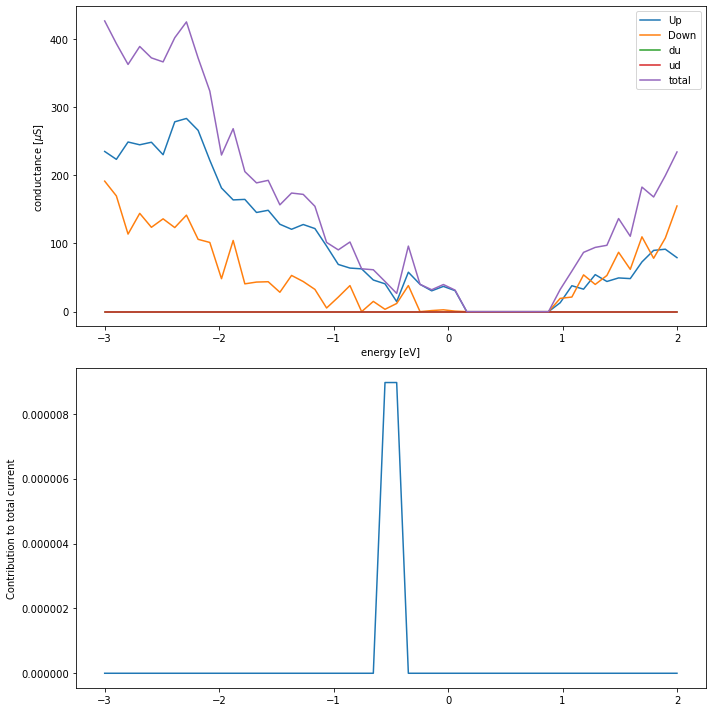

In [37]:

def fermi(eps, mu, T):
    return 1/(1+np.exp((eps-mu)/(k_b*T)))

def plot_conductance(syst, energies, mu_left, mu_right, temp, params, silent=False):
    # Compute transmission as a function of energy
    spin_ups = []
    spin_downs = []
    down_up = []
    up_down = []
    total = []
    conductance_quantum = q_e**2/h
    data2 = []
    current_sum = 0
    dE = energies[1] - energies[0]

    iter_energies = energies
    if not silent:
        iter_energies = tqdm(iter_energies)

    for energy in iter_energies:
        smatrix = kwant.smatrix(syst, energy, params = params)

        # total conductance
        spin_ups.append(smatrix.transmission((1,0), (0,0)) * conductance_quantum)
        spin_downs.append(smatrix.transmission((1,1), (0,1)) * conductance_quantum)

        down_up.append(smatrix.transmission((1,0), (0,1)) * conductance_quantum)
        up_down.append(smatrix.transmission((1,1), (0,0)) * conductance_quantum)
        total.append(smatrix.transmission(1,0) * conductance_quantum)
        # smatrix.transmission((1,0), (0,0)) # look at spin ups

        if down_up[-1] != 0 or up_down[-1] != 0:
            print("something odd is afoot")


        occupation_difference = (fermi(energy,mu_left, temp) - fermi(energy, mu_right, temp))
        current_sum += dE * total[-1] * occupation_difference / q_e
        # data2.append(dE * total[-1] * conductance_quantum * occupation_difference / q_e)
        data2.append(occupation_difference)

    if not silent:
        fig, axs = plt.subplots(2,figsize=(10,10))
        axs[0].plot(energies/ev_to_j, np.array(spin_ups) * 1e6, label="Up")
        axs[0].plot(energies/ev_to_j, np.array(spin_downs) * 1e6, label = "Down")
        axs[0].plot(energies/ev_to_j, np.array(down_up) * 1e6, label="du")
        axs[0].plot(energies/ev_to_j, np.array(up_down) * 1e6, label = "ud")
        axs[0].plot(energies/ev_to_j, np.array(total) * 1e6, label = "total")
        axs[0].set_xlabel("energy [eV]")
        axs[0].set_ylabel("conductance [$\mu$S]")
        axs[0].legend()

        axs[1].plot(energies/ev_to_j, data2)
        axs[1].set_ylabel("Contribution to total current")

        plt.tight_layout()
        plt.savefig("graphs/conductance plot")
        plt.show()
    return current_sum, energies, total, spin_downs, spin_ups


def plot_bandstructure(flead, momenta):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k)/ev_to_j for k in tqdm(momenta)]

    plt.figure(figsize=(10,6))
    plt.plot(momenta, energies,alpha=0.5)

    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [ev]")
    plt.grid()
    plt.show()
    return energies



def plot_spectrum(syst, Bfields, k):
    energies = []
    for B in tqdm(Bfields):
        # Obtain the Hamiltonian as a sparse matrix
        ham_mat = syst.hamiltonian_submatrix(params=dict(B=0, E_z=B), sparse=True)

        # we only calculate the k lowest eigenvalues
        ev = sla.eigsh(ham_mat.tocsc(), k=k, sigma=0,
                       return_eigenvectors=False)

        energies.append(ev)

    return Bfields, energies





# Do conductance plotting

params=dict(B=0, E_z = 0.5*ev_to_j)
temp = 50
doping_level = -.5 * ev_to_j
span = max(2.5*ev_to_j, left_pot - right_pot)
v_sd = 5/1000
left_pot = v_sd / 2 * ev_to_j
right_pot = -v_sd / 2 * ev_to_j

energies = np.linspace(-span + doping_level, span + doping_level , 50)
out = plot_conductance(syst, energies, doping_level+left_pot, doping_level+right_pot, temp,
                 params = params, silent=False)



0.12541806020066903
143


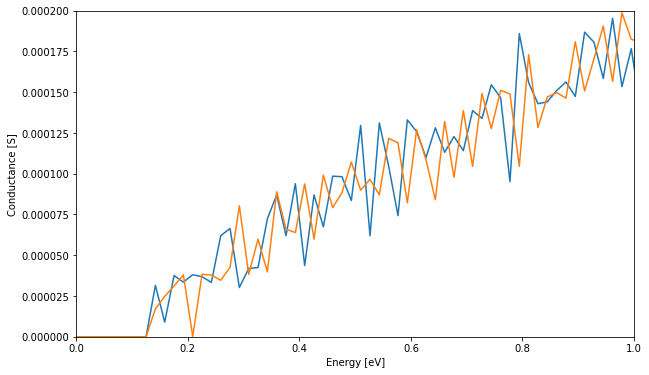

In [89]:

plt.figure(figsize=(10,6))


out = np.load("data/150_angstroms/5mV_gapless.npy", allow_pickle=True)
E_z = 10/1000 * ev_to_j
current, energies, total, spin_downs, spin_ups = out
# plt.plot((energies-E_z)/ev_to_j, spin_downs, "--")
# plt.plot((energies+E_z)/ev_to_j, spin_ups,"--")


out = np.load("data/150_angstroms/5mV_Z10meV.npy", allow_pickle=True)

current, energies, total, spin_downs, spin_ups = out
plt.plot(energies/ev_to_j, spin_downs)
plt.plot(energies/ev_to_j, spin_ups)



plt.xlim(0,1)
plt.ylim(0,2e-4)

plt.xlabel("Energy [eV]")
plt.ylabel("Conductance [S]")
plt.savefig("graphs/150 angstrom dot/conductance plot")

for i in range(1,len(energies)):
    if total[-i] == 0:
        print(energies[-i]/ev_to_j)
        print(i)
        break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


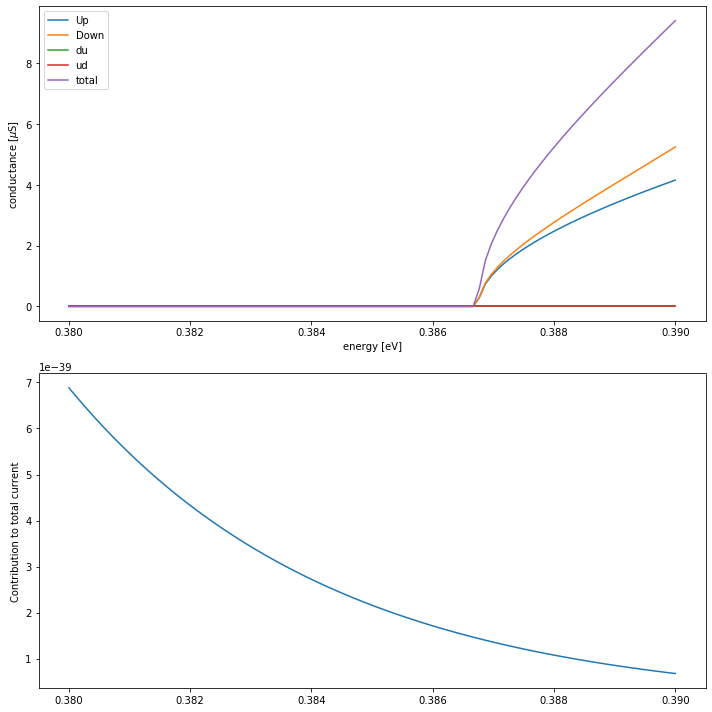

In [39]:
temp = 50
doping_level = 0 * ev_to_j
span = max(2.5*ev_to_j, left_pot - right_pot)
v_sd = 5/1000
left_pot = v_sd / 2 * ev_to_j
right_pot = -v_sd / 2 * ev_to_j
syst = make_system(r=50, t=-t, left_pot=left_pot, right_pot=right_pot, tp=None, leads=True,
                   parallel = True)
syst = syst.finalized()

# energies = np.linspace(-span + doping_level, span + doping_level , 1000)
energies = np.linspace(0.38, 0.39, 100) * ev_to_j
params = dict(B=0, E_z = 0.01*ev_to_j)

out = \
    plot_conductance(syst, energies, doping_level+left_pot, doping_level+right_pot, temp,
                     params = params, silent=False)

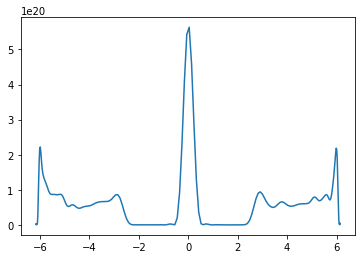

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 600.15it/s]


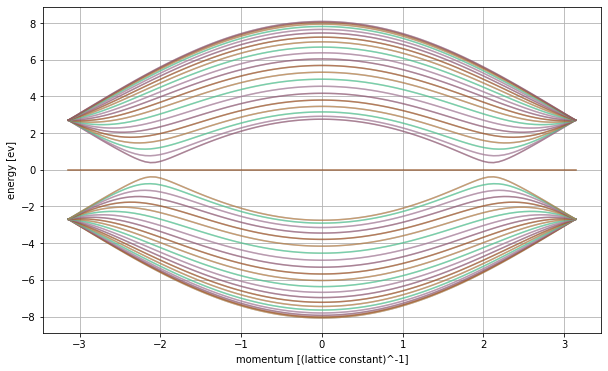

[array([-2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00,
        -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00,
        -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00,
        -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00,
        -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00,
        -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00,
        -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00,
        -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00, -2.6975e+00,
        -2.6975e+00, -2.6975e+00,  2.5000e-03,  2.5000e-03,  2.7025e+00,
         2.7025e+00,  2.7025e+00,  2.7025e+00,  2.7025e+00,  2.7025e+00,
         2.7025e+00,  2.7025e+00,  2.7025e+00,  2.7025e+00,  2.7025e+00,
         2.7025e+00,  2.7025e+00,  2.7025e+00,  2.7025e+00,  2.7025e+00,
         2.7025e+00,  2.7025e+00,  2.7025e+00,  2.7025e+00,  2.7025e+00,
         2.7025e+00,  2.7025e+00,  2.7025e+00,  2.7

In [49]:
spectrum = kwant.kpm.SpectralDensity(syst.leads[0], rng=0, params=params)
energies, densities = spectrum()
plt.plot(energies/ev_to_j, densities)
plt.show()
params = dict(B=0, E_z=0.01*ev_to_j)

moments = np.linspace(-pi, pi, 100)
plot_bandstructure(syst.leads[0], moments)

# def spin_up_map(i):
#     spin_up_mask = tinyarray.array([[1,0],[0,0]])
#     hamiltonian = syst.hamiltonian(i, i, params=params)
#     return np.sum(spin_up_mask * hamiltonian)/ ev_to_j
# kwant.plotter.map(syst, spin_up_map);
#
# def spin_down_map(i):
#     spin_down_mask = tinyarray.array([[0,0],[0,1]])
#     hamiltonian = syst.hamiltonian(i, i, params=params)
#     return np.sum(spin_down_mask * hamiltonian)/ ev_to_j
# kwant.plotter.map(syst, spin_down_map);